In [2]:
import pandas as pd
import pandas as pd, numpy as np
from pathlib import Path
import fsspec

Question 1

In [ ]:
def station_data(station_id):
    
    # Receives a GHCN Station ID string and returns record daily max,
    # average daily max, record daily min and average daily min for 
    # the period 1991-2020
    
    begin_date = "1-Jan-1990"
    end_date = "31-Dec-2020"

    download_string = "s3://noaa-ghcn-pds/csv/by_station/" + str(station_id) + ".csv"
    df = pd.read_csv( 
                     download_string,
                     storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
                     dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
                     parse_dates=['DATE']
                     ).set_index('DATE')
    
    # Filtering for date
    df = df[(df.index >= pd.to_datetime(begin_date)) & (df.index <= pd.to_datetime(end_date))]

    df_daily_min = df[(df['ELEMENT'] == 'TMIN')]
    df_daily_max = df[(df['ELEMENT'] == 'TMAX')]
    
    min_min = df_daily_min.groupby(df_daily_min.index.dayofyear)['DATA_VALUE'].min()
    max_max = df_daily_max.groupby(df_daily_max.index.dayofyear)['DATA_VALUE'].max()
    min_average = df_daily_min.groupby(df_daily_min.index.dayofyear)['DATA_VALUE'].mean()
    max_average = df_daily_max.groupby(df_daily_max.index.dayofyear)['DATA_VALUE'].mean()

    result = pd.DataFrame({"record_min_temp": min_min, 
                           "average_min_temp": min_average, 
                           "average_max_temp": max_average,
                           "record_max_temp": max_max},
                           )    

    return result



In [67]:
Patuxent_River_MD_stid = 'USC00186915'
Louisville_KY_stid = 'USC00154958'

df = station_data(Louisville_KY_stid)

In [70]:
df

,record_min_temp,average_min_temp,average_max_temp,record_max_temp
DATE,,,,
1,-16.7,-3.220833,6.783333,16.1
2,-18.3,-1.341667,6.462500,21.1
3,-15.0,-1.275000,7.108333,20.6
4,-15.0,-1.895833,8.212500,19.4
5,-16.7,-2.704167,6.087500,18.9
...,...,...,...,...
362,-12.2,-1.120833,8.358333,20.0
363,-10.0,-1.733333,7.137500,18.3
364,-11.7,-1.520833,6.375000,15.6


Question 2

<Axes: xlabel='DATE'>

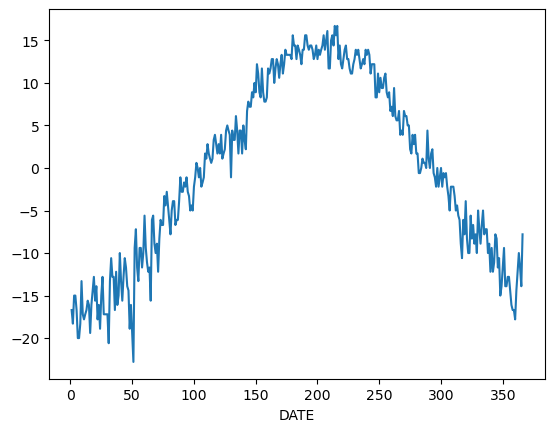

In [ ]:
df['record_min_temp'].plot()